# Qiskit and IonQ on Azure Quantum For snake Game



First, import the required packages for this sample:

In [1]:
from qiskit import QuantumCircuit
from qiskit.visualization import plot_histogram
from qiskit.tools.monitor import job_monitor
from azure.quantum.qiskit import AzureQuantumProvider


## Connecting to the Azure Quantum service

To connect to the Azure Quantum service, use the `AzureQuantumProvider` constructor to create a `provider` object that connects to your Azure Quantum workspace. This will use your workspace's resource ID and location.


In [2]:
from azure.quantum.qiskit import AzureQuantumProvider
provider = AzureQuantumProvider (
    resource_id = "/subscriptions/b1d7f7f8-743f-458e-b3a0-3e09734d716d/resourceGroups/aq-hackathons/providers/Microsoft.Quantum/Workspaces/aq-hackathon-01",
    location = "eastus"
)

## References

<a id="1">[1]</a>   _Quantum agents in the Gym: a variational quantum algorithm for deep Q-learning_ (2021, Skolik et al.). [arXiv:2103.15084](https://arxiv.org/abs/2103.15084)

<a id="2">[2]</a> [Approximate Q-Learning algorithm](https://github.com/ageron/handson-ml2), Github.

## Basic snake game Reinforcement learning

The process workflow has been explained in README.md about snake game development

In [18]:

import numpy as np
import random


class BodyNode():
    def __init__(self, parent, x, y):
        self.parent = parent
        self.x = x
        self.y = y

    def setX(self, x):
        self.x = x

    def setY(self, y):
        self.y = y

    def setParent(self, parent):
        self.parent = parent

    def getPosition(self):
        return (self.x, self.y)
    
    def getIndex(self):
        return (self.y, self.x)


class Snake():
    def __init__(self, x, y):
        self.head = BodyNode(None, x, y)
        self.tail = self.head

    def moveBodyForwards(self):
        currentNode = self.tail
        while currentNode.parent != None:
            parentPosition = currentNode.parent.getPosition()
            currentNode.setX(parentPosition[0])
            currentNode.setY(parentPosition[1])
            currentNode = currentNode.parent

    def move(self, direction):
        (oldTailX, oldTailY) = self.tail.getPosition()
        self.moveBodyForwards()
        headPosition = self.head.getPosition()
        if direction == 0:
            self.head.setY(headPosition[1] - 1)
        elif direction == 1:
            self.head.setX(headPosition[0] + 1)
        elif direction == 2:
            self.head.setY(headPosition[1] + 1)
        elif direction == 3:
            self.head.setX(headPosition[0] - 1)
        return (oldTailX, oldTailY, *self.head.getPosition())

    def newHead(self, newX, newY):
        newHead = BodyNode(None, newX, newY)
        self.head.setParent(newHead)
        self.head = newHead
        
    def getHead(self):
        return self.head
    
    def getTail(self):
        return self.tail


class SnakeGame():
    def __init__(self, width, height):
        # arbitrary numbers to signify head, body, and food)
        # 0 for empty space
        self.headVal = 2
        self.bodyVal = 1
        self.foodVal = 7
        self.width = width
        self.height = height
        self.board = np.zeros([height, width], dtype=int)

        self.length = 1

        startX = width//2
        startY = height//2

        self.board[startX, startY] = self.headVal
        self.snake = Snake(startX, startY)
        self.spawnFood()
        self.calcState()
#        print(self.board)

    def spawnFood(self):
        # spawn food at location not occupied by snake
        emptyCells = []
        for index, value in np.ndenumerate(self.board):
            if value != self.bodyVal and value != self.headVal:
                emptyCells.append(index)
        self.foodIndex = random.choice(emptyCells)
        self.board[self.foodIndex] = self.foodVal

    def checkValid(self, direction):
        # check if move is blocked by wall
        newX, newY = self.potentialPosition(direction)
        if newX == -1 or newX == self.width:
            return False
        if newY == -1 or newY == self.height:
            return False
        # check if move is blocked by snake body
        if self.board[newY, newX] == self.bodyVal:
            return False
        return True

    def potentialPosition(self, direction):
        (newX, newY) = self.snake.getHead().getPosition()
        if direction == 0:
            newY -= 1
        elif direction == 1:
            newX += 1
        elif direction == 2:
            newY += 1
        elif direction == 3:
            newX -= 1
        return (newX, newY)

    def calcState(self):
        # state is as follows.
        # Is direction blocked by wall or snake?
        # Is food in this direction?
        # (top blocked, right blocked, down blocked, left blocked,
        # top food, right food, down food, left food)
        self.state = np.zeros(8, dtype=int)
        for i in range(4):
            self.state[i] = not self.checkValid(i)
        self.state[4:] = self.calcFoodDirection()

    def calcStateNum(self):
        # calculate an integer number for state
        # there will be 2^8 potential states but not all states are reachable
        stateNum = 0
        for i in range(8):
            stateNum += 2**i*self.state[i]
        return stateNum

    def calcFoodDirection(self):
        # food can be 1 or 2 directions eg. right and up
        # 0 is up, 1 is right, 2 is down, 3 is left
        foodDirections = np.zeros(4, dtype=int)
        dist = np.array(self.foodIndex) - np.array(self.snake.getHead().getIndex())
        if dist[0] < 0:
            # down
            foodDirections[0] = 1
        elif dist[0] > 0:
            # up
            foodDirections[2] = 1
        if dist[1] > 0:
            # right
            foodDirections[1] = 1
        elif dist[1] < 0:
            # left
            foodDirections[3] = 1
        return foodDirections

    def plottableBoard(self):
        #returns board formatted for animations
        board = np.zeros([self.width, self.height])
        currentNode = self.snake.tail
        count = 0
        while True:
            count += 1
            board[currentNode.getIndex()] = 0.2 + 0.8*count/self.length
            currentNode = currentNode.parent
            if currentNode == None:
                break
        board[self.foodIndex] = -1
        return board
        
        
    def display(self):
        for i in range(self.width+2):
            print('-', end='')
        for i in range(self.height):
            print('\n|', end='')
            for j in range(self.width):
                if self.board[i, j] == 0:
                    print(' ', end='')
                elif self.board[i, j] == self.headVal:
                    print('O', end='')
                elif self.board[i, j] == self.bodyVal:
                    print('X', end='')
                elif self.board[i, j] == self.foodVal:
                    print('*', end='')
            print('|', end='')
        print()
        for i in range(self.width+2):
            print('-', end='')
        print()
#        print(self.board)

    def makeMove(self, direction):
        gameOver = False
        if self.checkValid(direction):
            # set reward if moving in the right direction
            if self.calcFoodDirection()[direction] == 1:
                reward = 1
            else:
                reward = 0
            (headX, headY) = self.snake.getHead().getPosition()
            # set old head to body val
            self.board[headY, headX] = self.bodyVal

            # check if we got the fruit
            potX, potY = self.potentialPosition(direction)
            if self.board[potY, potX] == self.foodVal:
                # extend the snake
                self.snake.newHead(potX, potY)
                self.board[potY, potX] = self.headVal
                self.spawnFood()
                self.length += 1
                # if you want to give a higher reward for getting the fruit, uncomment below
                reward = 2
            else:
                # move the snake
                (oldTailX, oldTailY, newHeadX, newHeadY) = self.snake.move(direction)
                self.board[oldTailY, oldTailX] = 0
                self.board[newHeadY, newHeadX] = self.headVal
        else:
            reward = -2
            gameOver = True
        self.calcState()
        return (self.calcStateNum(), reward, gameOver, self.length)


if __name__ == "__main__":
    game = SnakeGame(8, 8)
    game.display()
    print("Score: 1")
    while True:
        direction = input("Input Direction (w,a,s,d or q to quit): ")
        if direction == 'w':
            new_state, reward, gameOver, score = game.makeMove(0)
        elif direction == 'a':
            new_state, reward, gameOver, score = game.makeMove(3)
        elif direction == 's':
            new_state, reward, gameOver, score = game.makeMove(2)
        elif direction == 'd':
            new_state, reward, gameOver, score = game.makeMove(1)
        elif direction == 'q':
            break
        if gameOver:
            print("Game Over, Score:", score)
            break
        else:
            game.display()
            print("Reward:", reward, "Score:", score)


----------
|        |
|        |
|        |
|  *     |
|    O   |
|        |
|        |
|        |
----------
Score: 1
----------
|        |
|        |
|        |
|  * O   |
|        |
|        |
|        |
|        |
----------
Reward: 1 Score: 1
----------
|        |
|        |
|    O   |
|  *     |
|        |
|        |
|        |
|        |
----------
Reward: 0 Score: 1
----------
|        |
|    O   |
|        |
|  *     |
|        |
|        |
|        |
|        |
----------
Reward: 0 Score: 1
----------
|    O   |
|        |
|        |
|  *     |
|        |
|        |
|        |
|        |
----------
Reward: 0 Score: 1
Game Over, Score: 1




The machine can sometimes become trapped in an endless loop of non-scoring moves.


Training for 10001 games...
Episode 0 Average snake length without exploration: 1.04
Episode 100 Average snake length without exploration: 5.36
Episode 200 Average snake length without exploration: 5.68
Episode 300 Average snake length without exploration: 4.28
Episode 400 Average snake length without exploration: 8.52
Episode 500 Average snake length without exploration: 8.4
Episode 600 Average snake length without exploration: 9.24
Episode 700 Average snake length without exploration: 10.2
Episode 800 Average snake length without exploration: 15.36
Episode 900 Average snake length without exploration: 14.68
Episode 1000 Average snake length without exploration: 4.52
Episode 1100 Average snake length without exploration: 20.16
Episode 1200 Average snake length without exploration: 18.36
Episode 1300 Average snake length without exploration: 17.84
Episode 1400 Average snake length without exploration: 18.4
Episode 1500 Average snake length without exploration: 20.0
Episode 1600 Average

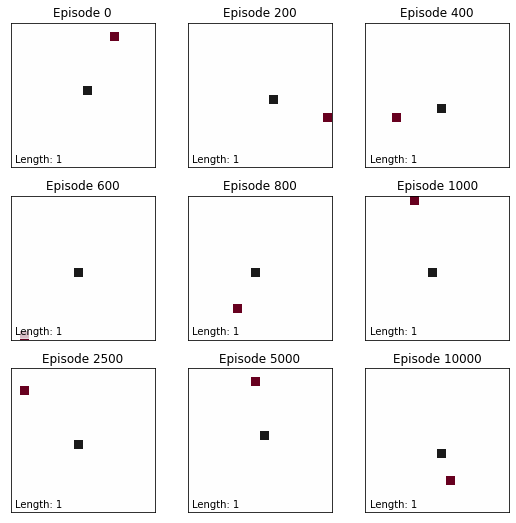

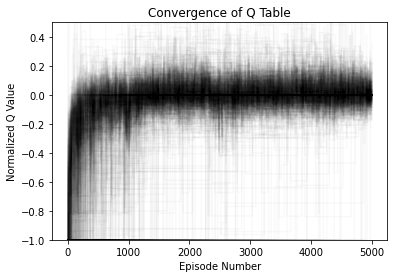

In [19]:

import random

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
#%%

def evaluateScore(Q, boardDim, numRuns, displayGame=False):
    # Run the game for a specified number of runs given a specific Q matrix
    cutoff = 100  # X moves without increasing score will cut off this game run
    scores = []
    for i in range(numRuns):
        game = SnakeGame(boardDim, boardDim)
        state = game.calcStateNum()
        score = 0
        oldScore = 0
        gameOver = False
        moveCounter = 0
        while not gameOver:
            possibleQs = Q[state, :]
            action = np.argmax(possibleQs)
            state, reward, gameOver, score = game.makeMove(action)
            if score == oldScore:
                moveCounter += 1
            else:
                oldScore = score
                moveCounter = 0
            if moveCounter >= cutoff:
                # stuck going back and forth
                break
        scores.append(score)
    return np.average(scores), scores



boardDim = 16  # size of the baord

# state is as follows.
# Is direction blocked by wall or snake?
# Is food in this direction? can either be one or two directions eg (food is left) or (food is left and up)
# state =  (top blocked, right blocked, down blocked, left blocked, up food, right food, down food, left food)
# 8 boolean values. Not all states are reachable (eg states with food directions that don't make sense)
numStates = 2**8
numActions = 4  # 4 directions that the snake can move
Q = np.zeros((numStates, numActions))

# lr = 0.9 #learning rate. not used in this Q learning equation
gamma = 0.8  # discount rate
epsilon = 0.2  # exploration rate in training games
numEpisodes = 10001  # number of games to train for nanti di ganti 100001

Qs = np.zeros([numEpisodes, numStates, numActions])
bestLength = 0
print("Training for", numEpisodes, "games...")
for episode in range(numEpisodes):
    #    print("New Game")
    game = SnakeGame(boardDim, boardDim)
    state = game.calcStateNum()
    gameOver = False
    score = 0
    while not gameOver:
        if random.uniform(0, 1) < epsilon:
            action = random.randint(0, 3)
        else:
            possibleQs = Q[state, :]
            action = np.argmax(possibleQs)
        new_state, reward, gameOver, score = game.makeMove(action)
        Q[state, action] = reward + gamma * np.max(Q[new_state, :])
        state = new_state
    Qs[episode, :, :] = np.copy(Q)
    if episode % 100 == 0:
        averageLength, lengths = evaluateScore(Q, boardDim, 25)
        if averageLength > bestLength:
            bestLength = averageLength
            bestQ = np.copy(Q)
        print("Episode", episode, "Average snake length without exploration:", averageLength)
        

print("Generating data for animation...")
#plotEpisodes = [0, 200, 300, 400, 500, 600, 700, 800, 900]
plotEpisodes = [0, 200, 400, 600, 800, 1000, 2500, 5000, 10000]
fig, axes = plt.subplots(3, 3, figsize=(9,9))

axList = []
ims = []
dataArrays = []
scores = []
labels = []

for i, row in enumerate(axes):
    for j, ax in enumerate(row):
        ax.set_title("Episode " + str(plotEpisodes[i*len(row) + j]))
        ax.get_yaxis().set_visible(False)
        ax.get_xaxis().set_visible(False)
        axList.append(ax)
        ims.append(ax.imshow(np.zeros([boardDim, boardDim]), vmin=-1, vmax=1, cmap='RdGy'))
        labels.append(ax.text(0,15, "Length: 0", bbox={'facecolor':'w', 'alpha':0.75, 'pad':1, 'edgecolor':'white'}))
        dataArrays.append(list())
        scores.append(list())
        
stopAnimation = False
maxFrames = 1000
cutoff = 100
numGames = 10
for k in range(numGames):
    games = []
    states = []
    gameOvers = []
    moveCounters = []
    oldScores = []
    for l in range(len(plotEpisodes)):
        game = SnakeGame(boardDim, boardDim)
        games.append(game)
        states.append(game.calcStateNum())
        gameOvers.append(False)
        moveCounters.append(0)
        oldScores.append(0)
    for j in range(maxFrames):
        for i in range(len(plotEpisodes)):
            possibleQs = Qs[plotEpisodes[i], :, :][states[i], :]
            action = np.argmax(possibleQs)
            states[i], reward, gameOver, score = games[i].makeMove(action)
            if gameOver:
                gameOvers[i] = True
            dataArrays[i].append(games[i].plottableBoard())
            scores[i].append(score)
            if score == oldScores[i]:
                moveCounters[i] += 1
            else:
                oldScores[i] = score
                moveCounters[i] = 0
            if moveCounters[i] >= cutoff:
                gameOvers[i] = True
        if not any(gameOver == False for gameOver in gameOvers):
            print("Game", k, "finished, total moves:", len(dataArrays[0]))
            break

def animate(frameNum):
    for i, im in enumerate(ims):
        labels[i].set_text("Length: " + str(scores[i][frameNum]))
        ims[i].set_data(dataArrays[i][frameNum])
    return ims+labels
print("Animating snakes at different episodes...")

numFrames = len(dataArrays[0])
ani = animation.FuncAnimation(fig, func=animate, frames=numFrames,blit=True, interval=75, repeat=False, )
plt.show(block=False)


usedQs = []
for index, val in np.ndenumerate(Qs[0,:,:]):
    qLine = Qs[:, index[0], index[1]][:5000]
    if any([item != 0 for item in qLine]) and qLine[-1] != 0:
        usedQs.append(np.copy(qLine))
        
usedQs = np.abs(usedQs)
y = []
finalVals = []
for i in range(len(usedQs)):
    finalVal = np.mean(usedQs[i][-100:])
    finalVals.append(finalVal)
    y = (usedQs[i]-finalVal) / finalVal
    plt.plot(y,color="black",alpha=0.025)
plt.ylim(-1,0.5)
plt.title("Convergence of Q Table")
plt.ylabel("Normalized Q Value")
plt.xlabel("Episode Number")
plt.savefig("ConvergenceGraph.png", dpi=300)
plt.show()

### For install package qiskit-machine-learning

In [5]:
pip install qiskit-machine-learning

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 117 kB 16.1 MB/s            
     |████████████████████████████████| 133 kB 54.9 MB/s            
  Preparing metadata (setup.py) ... - done
     |████████████████████████████████| 24.8 MB 216 kB/s             
     |████████████████████████████████| 306 kB 38.9 MB/s            
  Created wheel for fastdtw: filename=fastdtw-0.3.4-py3-none-any.whl size=3582 sha256=f51db7dca8e667a79da86d175043951a248674e2eb676648512c44bc6bdbf8de
  Stored in directory: /home/jovyan/.cache/pip/wheels/a2/da/8c/2d1b9b233595056f05e59156bb555f7277b88beb385605de16
Successfully built fastdtw
Note: you may need to restart the kernel to use updated packages.


Use `provider.backends` to see what targets are currently available. Running this method will trigger authentication to your Microsoft account, if you're not already logged in.

### For installl torch

In [6]:
pip install torch 

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 881.9 MB 470 bytes/s          07
     |████████████████████████████████| 23.2 MB 26.2 MB/s            
     |████████████████████████████████| 2.9 MB 38.3 MB/s            
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
Note: you may need to restart the kernel to use updated packages.


### For install Gym

In [7]:
pip install gym

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 1.5 MB 12.6 MB/s            
  Preparing metadata (setup.py) ... - done
  Created wheel for gym: filename=gym-0.21.0-py3-none-any.whl size=1616822 sha256=febe4b62a81bfcc1547d20cbb89488e77e9e08df893c8d8fac2a659b8568640c
  Stored in directory: /home/jovyan/.cache/pip/wheels/76/ee/9c/36bfe3e079df99acf5ae57f4e3464ff2771b34447d6d2f2148
Successfully built gym
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
basis-set-exchange 0.9 requires importlib-metadata<3; python_version == "3.7", but you have importlib-metadata 4.10.1 which is incompatible.
Note: you may need to restart the kernel to use updated packages.


### Import packages

In [2]:
# General imports
import numpy as np
import matplotlib.pyplot as plt

# Qiskit Circuit imports
from qiskit.circuit import QuantumCircuit, QuantumRegister, Parameter, ParameterVector, ParameterExpression
from qiskit.circuit.library import TwoLocal

# Qiskit imports
import qiskit as qk
from qiskit.utils import QuantumInstance

# Qiskit Machine Learning imports
import qiskit_machine_learning as qkml
from qiskit_machine_learning.neural_networks import CircuitQNN
from qiskit_machine_learning.connectors import TorchConnector

# PyTorch imports
import torch
from torch import Tensor
from torch.nn import MSELoss
from torch.optim import LBFGS, SGD, Adam, RMSprop

# OpenAI Gym import
import gym

# Fix seed for reproducibility
seed = 42
np.random.seed(seed)
torch.manual_seed(seed);

# To get smooth animations on Jupyter Notebooks. 
# Note: these plotting function are taken from https://github.com/ageron/handson-ml2
import matplotlib as mpl
import matplotlib.animation as animation
mpl.rc('animation', html='jshtml')

def update_scene(num, frames, patch):
    patch.set_data(frames[num])
    return patch,

def plot_animation(frames, repeat=False, interval=40):
    fig = plt.figure()
    patch = plt.imshow(frames[0])
    plt.axis('off')
    anim = animation.FuncAnimation(
        fig, update_scene, fargs=(frames, patch),
        frames=len(frames), repeat=repeat, interval=interval)
    plt.close()
    return anim


### Fuction encoding_circuit and parametrized_circuit [[1]](#1)

`encoding_circuit` for load classical inputs. The input are state variable of `CartPole` environtment.

`parametrized_circuit` encoding plus variation ansatz. 

In [3]:
def encoding_circuit(inputs, num_qubits = 4, *args):
    qc = qk.QuantumCircuit(num_qubits)
    
    # Encode data with a RX rotation
    for i in range(len(inputs)): 
        qc.rx(inputs[i], i)
        
    return qc

def parametrized_circuit(num_qubits = 4, reuploading = False, reps = 2, insert_barriers = True, meas = False):
    qr = qk.QuantumRegister(num_qubits, 'qr')
    qc = qk.QuantumCircuit(qr)
    
    if meas:
        qr = qk.QuantumRegister(num_qubits, 'qr')
        cr = qk.ClassicalRegister(num_qubits, 'cr')
        qc = qk.QuantumCircuit(qr,cr)
    
    
    if not reuploading:
        
        # Define a vector containg Inputs as parameters (*not* to be optimized)
        inputs = qk.circuit.ParameterVector('x', num_qubits)
                
        # Encode classical input data
        qc.compose(encoding_circuit(inputs, num_qubits = num_qubits), inplace = True)
        if insert_barriers: qc.barrier()
        
        # Variational circuit
        qc.compose(TwoLocal(num_qubits, ['ry', 'rz'], 'cz', 'circular', 
               reps=reps, insert_barriers= insert_barriers, 
               skip_final_rotation_layer = True), inplace = True)
        if insert_barriers: qc.barrier()
        
        # Add final measurements
        if meas: qc.measure(qr,cr)
        
    elif reuploading:
        
        # Define a vector containg Inputs as parameters (*not* to be optimized)
        inputs = qk.circuit.ParameterVector('x', num_qubits)
                
        # Define a vector containng variational parameters
        θ = qk.circuit.ParameterVector('θ', 2 * num_qubits * reps)
        
        # Iterate for a number of repetitions
        for rep in range(reps):

            # Encode classical input data
            qc.compose(encoding_circuit(inputs, num_qubits = num_qubits), inplace = True)
            if insert_barriers: qc.barrier()
                
            # Variational circuit (does the same as TwoLocal from Qiskit)
            for qubit in range(num_qubits):
                qc.ry(θ[qubit + 2*num_qubits*(rep)], qubit)
                qc.rz(θ[qubit + 2*num_qubits*(rep) + num_qubits], qubit)
            if insert_barriers: qc.barrier()
                
            # Add entanglers (this code is for a circular entangler)
            qc.cz(qr[-1], qr[0])
            for qubit in range(num_qubits-1):
                qc.cz(qr[qubit], qr[qubit+1])
            if insert_barriers: qc.barrier()
                        
        # Add final measurements
        if meas: qc.measure(qr,cr)
        
    return qc


### Create PQCs (Parametrized Quantum Circuit) [[1]](#1)

In [4]:


# Select the number of qubits
num_qubits = 4

# Generate the Parametrized Quantum Circuit (note the flags reuploading and reps)
qc = parametrized_circuit(num_qubits = num_qubits, 
                          reuploading = True, 
                          reps = 6)

# Fetch the parameters from the circuit and divide them in Inputs (X) and Trainable Parameters (params)
# The first four parameters are for the inputs 
X = list(qc.parameters)[: num_qubits]

# The remaining ones are the trainable weights of the quantum neural network
params = list(qc.parameters)[num_qubits:]

qc.draw()



┌──────────┐ ░ ┌──────────┐┌──────────┐ ░              ░ ┌──────────┐ ░ »
qr_0: ┤ Rx(x[0]) ├─░─┤ Ry(θ[0]) ├┤ Rz(θ[4]) ├─░──■──■────────░─┤ Rx(x[0]) ├─░─»
      ├──────────┤ ░ ├──────────┤├──────────┤ ░  │  │        ░ ├──────────┤ ░ »
qr_1: ┤ Rx(x[1]) ├─░─┤ Ry(θ[1]) ├┤ Rz(θ[5]) ├─░──┼──■──■─────░─┤ Rx(x[1]) ├─░─»
      ├──────────┤ ░ ├──────────┤├──────────┤ ░  │     │     ░ ├──────────┤ ░ »
qr_2: ┤ Rx(x[2]) ├─░─┤ Ry(θ[2]) ├┤ Rz(θ[6]) ├─░──┼─────■──■──░─┤ Rx(x[2]) ├─░─»
      ├──────────┤ ░ ├──────────┤├──────────┤ ░  │        │  ░ ├──────────┤ ░ »
qr_3: ┤ Rx(x[3]) ├─░─┤ Ry(θ[3]) ├┤ Rz(θ[7]) ├─░──■────────■──░─┤ Rx(x[3]) ├─░─»
      └──────────┘ ░ └──────────┘└──────────┘ ░              ░ └──────────┘ ░ »
«       ┌──────────┐┌───────────┐ ░              ░ ┌──────────┐ ░ ┌───────────┐»
«qr_0: ─┤ Ry(θ[8]) ├┤ Rz(θ[12]) ├─░──■──■────────░─┤ Rx(x[0]) ├─░─┤ Ry(θ[16]) ├»
«       ├──────────┤├───────────┤ ░  │  │        ░ ├──────────┤ ░ ├───────────┤»
«qr_1: ─┤ Ry(θ[9]) ├┤ Rz(θ[13]) ├─░──┼──■──■─────░─┤ Rx(x[1]) ├─░─┤ Ry(θ[17]) ├»
«      ┌┴──────────┤├───────────┤ ░  │     │     ░ ├──────────┤ ░ ├───────────┤»
«qr_2: ┤ Ry(θ[10]) ├┤ Rz(θ[14]) ├─░──┼─────■──■──░─┤ Rx(x[2]) ├─░─┤ Ry(θ[18]) ├»
«      ├───────────┤├───────────┤ ░  │        │  ░ ├──────────┤ ░ ├───────────┤»
«qr_3: ┤ Ry(θ[11]) ├┤ Rz(θ[15]) ├─░──■────────■──░─┤ Rx(x[3]) ├─░─┤ Ry(θ[19]) ├»
«      └───────────┘└───────────┘ ░              ░ └──────────┘ ░ └───────────┘»
«      ┌───────────┐ ░              ░ ┌──────────┐ ░ ┌───────────┐┌───────────┐»
«qr_0: ┤ Rz(θ[20]) ├─░──■──■────────░─┤ Rx(x[0]) ├─░─┤ Ry(θ[24]) ├┤ Rz(θ[28]) ├»
«      ├───────────┤ ░  │  │        ░ ├──────────┤ ░ ├───────────┤├───────────┤»
«qr_1: ┤ Rz(θ[21]) ├─░──┼──■──■─────░─┤ Rx(x[1]) ├─░─┤ Ry(θ[25]) ├┤ Rz(θ[29]) ├»
«      ├───────────┤ ░  │     │     ░ ├──────────┤ ░ ├───────────┤├───────────┤»
«qr_2: ┤ Rz(θ[22]) ├─░──┼─────■──■──░─┤ Rx(x[2]) ├─░─┤ Ry(θ[26]) ├┤ Rz(θ[30]) ├»
«      ├───────────┤ ░  │        │  ░ ├──────────┤ ░ ├───────────┤├───────────┤»
«qr_3: ┤ Rz(θ[23]) ├─░──■────────■──░─┤ Rx(x[3]) ├─░─┤ Ry(θ[27]) ├┤ Rz(θ[31]) ├»
«      └───────────┘ ░              ░ └──────────┘ ░ └───────────┘└───────────┘»
«       ░              ░ ┌──────────┐ ░ ┌───────────┐┌───────────┐ ░          »
«qr_0: ─░──■──■────────░─┤ Rx(x[0]) ├─░─┤ Ry(θ[32]) ├┤ Rz(θ[36]) ├─░──■──■────»
«       ░  │  │        ░ ├──────────┤ ░ ├───────────┤├───────────┤ ░  │  │    »
«qr_1: ─░──┼──■──■─────░─┤ Rx(x[1]) ├─░─┤ Ry(θ[33]) ├┤ Rz(θ[37]) ├─░──┼──■──■─»
«       ░  │     │     ░ ├──────────┤ ░ ├───────────┤├───────────┤ ░  │     │ »
«qr_2: ─░──┼─────■──■──░─┤ Rx(x[2]) ├─░─┤ Ry(θ[34]) ├┤ Rz(θ[38]) ├─░──┼─────■─»
«       ░  │        │  ░ ├──────────┤ ░ ├───────────┤├───────────┤ ░  │       »
«qr_3: ─░──■────────■──░─┤ Rx(x[3]) ├─░─┤ Ry(θ[35]) ├┤ Rz(θ[39]) ├─░──■───────»
«       ░              ░ └──────────┘ ░ └───────────┘└───────────┘ ░          »
«          ░ ┌──────────┐ ░ ┌───────────┐┌───────────┐ ░              ░ 
«qr_0: ────░─┤ Rx(x[0]) ├─░─┤ Ry(θ[40]) ├┤ Rz(θ[44]) ├─░──■──■────────░─
«          ░ ├──────────┤ ░ ├───────────┤├───────────┤ ░  │  │        ░ 
«qr_1: ────░─┤ Rx(x[1]) ├─░─┤ Ry(θ[41]) ├┤ Rz(θ[45]) ├─░──┼──■──■─────░─
«          ░ ├──────────┤ ░ ├───────────┤├───────────┤ ░  │     │     ░ 
«qr_2: ─■──░─┤ Rx(x[2]) ├─░─┤ Ry(θ[42]) ├┤ Rz(θ[46]) ├─░──┼─────■──■──░─
«       │  ░ ├──────────┤ ░ ├───────────┤├───────────┤ ░  │        │  ░ 
«qr_3: ─■──░─┤ Rx(x[3]) ├─░─┤ Ry(θ[43]) ├┤ Rz(θ[47]) ├─░──■────────■──░─
«          ░ └──────────┘ ░ └───────────┘└───────────┘ ░              ░

### import package

In [3]:
from qiskit import Aer
from qiskit import *

### install qiskit-aer

In [8]:
pip install qiskit-aer

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 18.0 MB 9.2 MB/s            
Note: you may need to restart the kernel to use updated packages.


In [6]:
qi = Aer.get_backend('statevector_simulator')

### Create PyTorch Model from the parametrized quantum circuit

 `CircuitQNN` and `TorchConnector` in `qiskit_machine_learning`

In [15]:
from qiskit_machine_learning.neural_networks import CircuitQNN

In [7]:
# Select a quantum backend to run the simulation of the quantum circuit


# Create a Quantum Neural Network object starting from the quantum circuit defined above
qnn = CircuitQNN(qc, input_params=X, weight_params=params, 
                 quantum_instance = qi)

# Connect to PyTorch
initial_weights = (2*np.random.rand(qnn.num_weights) - 1)
quantum_nn = TorchConnector(qnn, initial_weights)


In [8]:
class encoding_layer(torch.nn.Module):
    def __init__(self, num_qubits = 4):
        super().__init__()
        
        # Define weights for the layer
        weights = torch.Tensor(num_qubits)
        self.weights = torch.nn.Parameter(weights)
        torch.nn.init.uniform_(self.weights, -1, 1) # <--  Initialization strategy
    
        
    def forward(self, x):
        """Forward step, as explained above."""
        
        if not isinstance(x, Tensor):
            x = Tensor(x)
        
        x = self.weights * x
        x = torch.atan(x)
                
        return x

In [9]:
class exp_val_layer(torch.nn.Module):
    def __init__(self, action_space = 2):
        super().__init__()
        
        # Define the weights for the layer
        weights = torch.Tensor(action_space)
        self.weights = torch.nn.Parameter(weights)
        torch.nn.init.uniform_(self.weights, 35, 40) # <-- Initialization strategy (heuristic choice)
        
        # Masks that map the vector of probabilities to <Z_0*Z_1> and <Z_2*Z_3>
        self.mask_ZZ_12 = torch.tensor([1.,-1.,-1.,1.,1.,-1.,-1.,1.,1.,-1.,-1.,1.,1.,-1.,-1.,1.], requires_grad = False)
        self.mask_ZZ_34 = torch.tensor([-1.,-1.,-1.,-1.,1.,1.,1.,1.,-1.,-1.,-1.,-1.,1.,1.,1.,1.], requires_grad = False)
        
    def forward(self, x):
        """Forward step, as described above."""
        
        expval_ZZ_12 = self.mask_ZZ_12 * x
        expval_ZZ_34 = self.mask_ZZ_34 * x
        
        # Single sample
        if len(x.shape) == 1:
            expval_ZZ_12 = torch.sum(expval_ZZ_12)
            expval_ZZ_34 = torch.sum(expval_ZZ_34)
            out = torch.cat((expval_ZZ_12.unsqueeze(0), expval_ZZ_34.unsqueeze(0)))
        
        # Batch of samples
        else:
            expval_ZZ_12 = torch.sum(expval_ZZ_12, dim = 1, keepdim = True)
            expval_ZZ_34 = torch.sum(expval_ZZ_34, dim = 1, keepdim = True)
            out = torch.cat((expval_ZZ_12, expval_ZZ_34), 1)
                
        return self.weights * ((out + 1.) / 2.)


### Construct final model hybrid classical-quantum

`model` = `encoding_layer` --> `quantum_layer` --> `exp_val_layer`

In [10]:
# Classical trainable preprocessing
encoding = encoding_layer()

# Classical trainable postprocessing
exp_val = exp_val_layer()

# Stack the classical and quantum layers together 
model = torch.nn.Sequential(encoding, 
                            quantum_nn, 
                            exp_val)

model.state_dict()


OrderedDict([('0.weights', tensor([ 0.7645,  0.8300, -0.2343,  0.9186])),
             ('1.weight',
              tensor([-0.2509,  0.9014,  0.4640,  0.1973, -0.6880, -0.6880, -0.8838,  0.7324,
                       0.2022,  0.4161, -0.9588,  0.9398,  0.6649, -0.5753, -0.6364, -0.6332,
                      -0.3915,  0.0495, -0.1361, -0.4175,  0.2237, -0.7210, -0.4157, -0.2673,
                      -0.0879,  0.5704, -0.6007,  0.0285,  0.1848, -0.9071,  0.2151, -0.6590,
                      -0.8699,  0.8978,  0.9313,  0.6168, -0.3908, -0.8047,  0.3685, -0.1197,
                      -0.7559, -0.0096, -0.9312,  0.8186, -0.4824,  0.3250, -0.3766,  0.0401])),
             ('1._weights',
              tensor([-0.2509,  0.9014,  0.4640,  0.1973, -0.6880, -0.6880, -0.8838,  0.7324,
                       0.2022,  0.4161, -0.9588,  0.9398,  0.6649, -0.5753, -0.6364, -0.6332,
                      -0.3915,  0.0495, -0.1361, -0.4175,  0.2237, -0.7210, -0.4157, -0.2673,
                      -

### create CartPole environtment

In [11]:
env = gym.make("CartPole-v1")
input_shape = [4] # == env.observation_space.shape
n_outputs = 2 # == env.action_space.n


### Training Function

Use Appoximate Q-Learning Algorithm [[2]](#2)

In [12]:
from collections import deque

replay_memory = deque(maxlen=2000)


In [13]:
def epsilon_greedy_policy(state, epsilon=0):
    """Manages the transition from the *exploration* to *exploitation* phase"""
    if np.random.rand() < epsilon:
        return np.random.randint(n_outputs)
    else:
        with torch.no_grad():
            Q_values = model(Tensor(state)).numpy()
        return np.argmax(Q_values[0])
    
def sample_experiences(batch_size):
    """Sample some past experiences from the replay memory"""
    indices = np.random.randint(len(replay_memory), size=batch_size)
    batch = [replay_memory[index] for index in indices]
    states, actions, rewards, next_states, dones = [
        np.array([experience[field_index] for experience in batch])
        for field_index in range(5)]
    return states, actions, rewards, next_states, dones

def play_one_step(env, state, epsilon):
    """Perform one action in the environment and register the state of the system"""
    action = epsilon_greedy_policy(state, epsilon)
    next_state, reward, done, info = env.step(action)
    replay_memory.append((state, action, reward, next_state, done))
    return next_state, reward, done, info

def sequential_training_step(batch_size): 
    # Sample past experiences 
    experiences = sample_experiences(batch_size)
    states, actions, rewards, next_states, dones = experiences
    
    # Evaluates Target Q-values
    with torch.no_grad():
        next_Q_values = model(Tensor(next_states)).numpy()
    max_next_Q_values = np.max(next_Q_values, axis=1)
    target_Q_values = (rewards + (1 - dones) * discount_rate * max_next_Q_values)
    
    # Accumulate Loss sequentially (if batching data, gradients of the parameters are vanishing)
    loss = 0.
    for j, state in enumerate(states):
        single_Q_value = model(Tensor(state))
        Q_value = single_Q_value[actions[j]]
        loss += (target_Q_values[j] - Q_value)**2
    
    # Evaluate the gradients and update the parameters 
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

def training_step(batch_size):
    # Sample past experiences
    experiences = sample_experiences(batch_size)
    states, actions, rewards, next_states, dones = experiences
    
    # Evaluate Target Q-values
    with torch.no_grad():
        next_Q_values = model(Tensor(next_states)).numpy()
    max_next_Q_values = np.max(next_Q_values, axis=1)
    target_Q_values = (rewards +
                       (1 - dones) * discount_rate * max_next_Q_values)
    target_Q_values = target_Q_values.reshape(-1, 1)
    mask = torch.nn.functional.one_hot(Tensor(actions).long(), n_outputs)
    
    # Evaluate the loss
    all_Q_values = model(Tensor(states))
    Q_values = torch.sum(all_Q_values * mask, dim=1, keepdims=True)
    loss = loss_fn(Tensor(target_Q_values), Q_values)
    
    # Evaluate the gradients and update the parameters 
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()


### Define hyperparameters

In [14]:
batch_size = 16
discount_rate = 0.99
optimizer = Adam(model.parameters(), lr=1e-2)


In [15]:
import random

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
#%%

def evaluateScore(Q, boardDim, numRuns, displayGame=False):
    # Run the game for a specified number of runs given a specific Q matrix
    cutoff = 100  # X moves without increasing score will cut off this game run
    scores = []
    for i in range(numRuns):
        game = SnakeGame(boardDim, boardDim)
        state = game.calcStateNum()
        score = 0
        oldScore = 0
        gameOver = False
        moveCounter = 0
        while not gameOver:
            possibleQs = Q[state, :]
            action = np.argmax(possibleQs)
            state, reward, gameOver, score = game.makeMove(action)
            if score == oldScore:
                moveCounter += 1
            else:
                oldScore = score
                moveCounter = 0
            if moveCounter >= cutoff:
                # stuck going back and forth
                break
        scores.append(score)
    return np.average(scores), scores


In [22]:


rewards = [] 
best_score = 0

# We let the agent train for 2000 episodes
for episode in range(100):
    
    # Run enviroment simulation
    obs = env.reset()  
    
    # 200 is the target score for considering the environment solved
    for step in range(200):
        
        # Manages the transition from exploration to exploitation
        epsilon = max(1 - episode / 1500, 0.01)
        obs, reward, done, info = play_one_step(env, obs, epsilon)
        if done:
            break
    rewards.append(step)
    
    # Saving best agent
    if step >= best_score:
        # torch.save(model.state_dict(), './new_model_best_weights.pth') # Save best weights
        best_score = step
        
    print(f'Episode = {episode} Step = {step+1}')
    
    # Start training only after some exploration experiences  
    if episode > 20:
        sequential_training_step(batch_size)



Episode = 0 Step = 9
Episode = 1 Step = 62
Episode = 2 Step = 22
Episode = 3 Step = 46
Episode = 4 Step = 25
Episode = 5 Step = 19
Episode = 6 Step = 11
Episode = 7 Step = 9
Episode = 8 Step = 39
Episode = 9 Step = 20
Episode = 10 Step = 18
Episode = 11 Step = 10
Episode = 12 Step = 43
Episode = 13 Step = 14
Episode = 14 Step = 24
Episode = 15 Step = 17
Episode = 16 Step = 11
Episode = 17 Step = 21
Episode = 18 Step = 10
Episode = 19 Step = 22
Episode = 20 Step = 38
Episode = 21 Step = 14
Episode = 22 Step = 15
Episode = 23 Step = 15
Episode = 24 Step = 17
Episode = 25 Step = 13
Episode = 26 Step = 16
Episode = 27 Step = 50
Episode = 28 Step = 15
Episode = 29 Step = 15
Episode = 30 Step = 15
Episode = 31 Step = 34
Episode = 32 Step = 9
Episode = 33 Step = 15
Episode = 34 Step = 34
Episode = 35 Step = 12
Episode = 36 Step = 38
Episode = 37 Step = 36
Episode = 38 Step = 43
Episode = 39 Step = 20
Episode = 40 Step = 13
Episode = 41 Step = 20
Episode = 42 Step = 11
Episode = 43 Step = 25
E

Process ForkProcess-454:
Traceback (most recent call last):
FAILURE: Can not get job id, Resubmit the qobj to get job id. Terra job error: 'Keyboard interrupt in parallel_map.' 
  File "/usr/local/lib/python3.7/multiprocessing/queues.py", line 94, in get
    res = self._recv_bytes()
  File "/usr/local/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/usr/local/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.7/concurrent/futures/process.py", line 233, in _process_worker
    call_item = call_queue.get(block=True)
  File "/usr/local/lib/python3.7/multiprocessing/connection.py", line 216, in recv_bytes
    buf = self._recv_bytes(maxlength)
  File "/usr/local/lib/python3.7/multiprocessing/connection.py", line 407, in _recv_bytes
    buf = self._recv(4)
  File "/usr/local/lib/python3.7/multiprocessing/connection.py", line 379, in _recv
    chunk = read(handle, rema

In [4]:
qubit = 4
qc = QuantumCircuit(qubit,qubit)

# apply hadamard gates
qc.h(range(2,qubit))
qc.measure(range(qubit),range(qubit))


To get a result back quickly, use `provider.get_backend` to create a `Backend` object to connect to the IonQ Simulator back-end:

In [5]:
simulator_backend = provider.get_backend("ionq.simulator")

You can now run the program via the Azure Quantum service and get the result. The following cell will submit a job that runs the circuit with 100 shots:

In [7]:
job = simulator_backend.run(qc, shots=5000)
job_id = job.id()
print("Job id", job_id)

Job id 9e5b3734-81c1-11ec-9083-00155d9c6457


To monitor job progress, we can use the Qiskit `job_monitor` we imported earlier to keep track of the Job's status. Note that this call will block until the job completes:

In [8]:
job_monitor(job)

Job Status: job has successfully run


To wait until the job is completed and return the results, run:

In [9]:
result = job.result()

This returns a `qiskit.Result` object.

In [10]:
type(result)

qiskit.result.result.Result

In [11]:
print(result)

Result(backend_name='ionq.simulator', backend_version='1', qobj_id='circuit-0', job_id='9e5b3734-81c1-11ec-9083-00155d9c6457', success=True, results=[ExperimentResult(shots=5000, success=True, meas_level=2, data=ExperimentResultData(counts={'0000': 1250, '0100': 1250, '1000': 1250, '1100': 1250}, probabilities={'0000': 0.25, '0100': 0.25, '1000': 0.25, '1100': 0.25}), header=QobjExperimentHeader(meas_map='[0, 1, 2, 3]', name='circuit-0', num_qubits='4', qiskit='True'))])


Because this is an object native to the Qiskit package, we can use Qiskit's `result.get_counts` and `plot_histogram` to visualize the results. The results can return a sparse dictionary so to make sure all possible bitstring lables are represented we add them to `counts`.

{'000': 0, '001': 0, '010': 0, '011': 0, '100': 0, '101': 0, '110': 0, '111': 0, '0000': 1250, '0100': 1250, '1000': 1250, '1100': 1250}


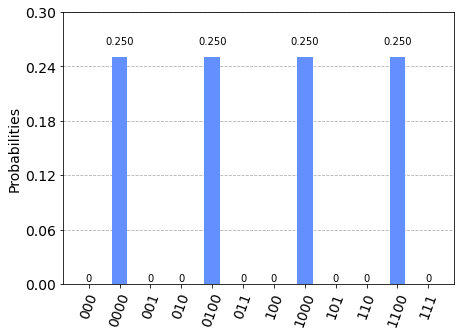

In [13]:
# The histogram returned by the results can be sparse, so here we add any of the missing bitstring labels.
counts = {format(n, "03b"): 0 for n in range(8)}
counts.update(result.get_counts(qc))
print(counts)
plot_histogram(counts)

### Run on IonQ QPU

To connect to real hardware (Quantum Processing Unit or QPU), simply provide the name of the target `"ionq.qpu"` to the `provider.get_backend` method:

In [5]:
qpu_backend = provider.get_backend("ionq.qpu")

Submit the circuit to run on Azure Quantum. Note that depending on queue times this may take a while to run!

Here we will again use the `job_monitor` to keep track of the job status, and `plot_histogram` to plot the results.

In [6]:
qpu_job = qpu_backend.run(qc, shots=1024)
job_id = qpu_job.id()
print("Job id", job_id)

Job id 636ee0d6-81cf-11ec-9f41-00155d9c6457


In [7]:
# Submit the circuit to run on Azure Quantum
qpu_job = qpu_backend.run(qc, shots=1024)
job_id = qpu_job.id()
print("Job id", job_id)

# Monitor job progress and wait until complete:
job_monitor(qpu_job)



Job id 6b0e05b0-81cf-11ec-9f41-00155d9c6457
Job Status: job has successfully run


Result(backend_name='ionq.qpu', backend_version='1', qobj_id='circuit-0', job_id='6b0e05b0-81cf-11ec-9f41-00155d9c6457', success=True, results=[ExperimentResult(shots=1024, success=True, meas_level=2, data=ExperimentResultData(counts={'0000': 271, '0010': 1, '0100': 244, '0110': 1, '1000': 249, '1001': 1, '1010': 1, '1100': 256}, probabilities={'0000': 0.2646484375, '0010': 0.0009765625, '0100': 0.23828125, '0110': 0.0009765625, '1000': 0.2431640625, '1001': 0.0009765625, '1010': 0.0009765625, '1100': 0.25}), header=QobjExperimentHeader(meas_map='[0, 1, 2, 3]', name='circuit-0', num_qubits='4', qiskit='True'))])
{'000': 0, '001': 0, '010': 0, '011': 0, '100': 0, '101': 0, '110': 0, '111': 0, '0000': 271, '0010': 1, '0100': 244, '0110': 1, '1000': 249, '1001': 1, '1010': 1, '1100': 256}


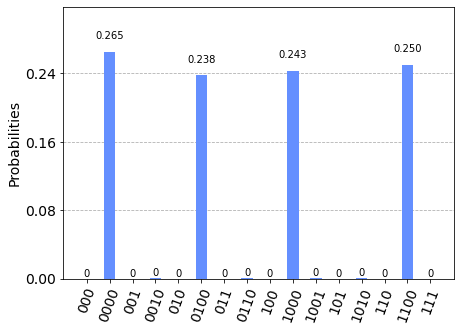

In [9]:
# Get the job results (this method also waits for the Job to complete):
result = qpu_job.result()
print(result)
counts = {format(n, "03b"): 0 for n in range(8)}
counts.update(result.get_counts(qc))
print(counts)
plot_histogram(counts)